## Exploring UMAP

In [2]:
%cd /nethome/bdevnani3/vis_lang/continual/src/

from model_wrapper import Bert
from models import alexnet
import torch
import torch.nn as nn
import numpy as np


from dataloaders import cifar100 as datagenerator
from omegaconf import OmegaConf
from main import init_root, cifar100_class_names

/nethome/bdevnani3/vis_lang/continual/src
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will

In [3]:
RUN = 0

# Set up dataloader
args = OmegaConf.load("./configs/cifar100_bert_icl_itl.yml")
args.data_dir = init_root()
args.ntasks = 20  # Doing this to get all the data as opposed to data divided into n tasks
args.seed = RUN
dataloader = datagenerator.DatasetGen(args)
taskcla= dataloader.taskcla

In [26]:
from collections import OrderedDict
MODEL_RANGE = 1
embs = []
tgts = []
for model in range(MODEL_RANGE+1):
#Load model
    net = alexnet.AlexNet(768)
    appr = Bert(model=net, class_names=cifar100_class_names)
    expt_path = f"/nethome/bdevnani3/raid/continual/cifar100_alexnet_bert_icl_itl/run_{RUN}/"
    state = torch.load(f"{expt_path}model_{model}.pth", map_location=torch.device('cpu'))
    appr.model.load_state_dict(state["net"])
    appr.model.eval()

    class_names = []
    class_embeddings = []
    targets = {}
    NUM_EMBEDDINGS_PER_CLASS = 50
    out_embeddings = []
    embeddings = OrderedDict()
    task_ids = []

    for task_set in range(0, model+1):
        dataset = dataloader.get(task_set)
        print(set(dataset[task_set]["train_labels"]))
        test_data_loader = dataset[task_set]['test']
        local_task_ids = list(set(dataset[task_set]["train_labels"]))
        task_ids.extend(local_task_ids)
        class_names.extend(np.array(appr.class_names)[local_task_ids])
        class_embeddings.extend(appr.model.word_lookup.cpu().numpy()[local_task_ids])
        for x in local_task_ids:
            embeddings[x] = []
            targets[x] = []
        classes_finished = 0

        for inputs, labels in test_data_loader:
            with torch.no_grad():
                embedding = appr.model(inputs).cpu().numpy()
                labels = labels.cpu().numpy()

            for i, label in enumerate(labels):
                if len(embeddings[label]) < NUM_EMBEDDINGS_PER_CLASS:
                    embeddings[label].append(embedding[i])
                    targets[label].append(label)
                    # Done with this class
                    if len(embeddings[label]) == NUM_EMBEDDINGS_PER_CLASS:
                        classes_finished += 1
            
            if classes_finished >= len(class_names):
                break
    print("-----------------------")
    print([k for k,v in embeddings.items()])
    print([k for k,v in targets.items()])
    print("-----------------------")
    emb_inp = np.concatenate([class_embeddings] + [np.stack(v, axis=0) for k,v in embeddings.items()], axis=0)
    tgts_inp = np.concatenate([task_ids] + [np.stack(v, axis=0) for k,v in targets.items()], axis=0)
    embs.append(emb_inp)
    tgts.append(tgts_inp)


Initializing stsb-bert-base...
Files already downloaded and verified
Files already downloaded and verified
Training set size:   2125 images of 32x32
Validation set size: 375 images of 32x32
Train+Val  set size: 2500 images of 32x32
Test set size:       500 images of 32x32
{2, 75, 86, 55, 26}
-----------------------
[2, 75, 86, 55, 26]
[2, 75, 86, 55, 26]
-----------------------
Initializing stsb-bert-base...
Files already downloaded and verified
Files already downloaded and verified
Training set size:   2125 images of 32x32
Validation set size: 375 images of 32x32
Train+Val  set size: 2500 images of 32x32
Test set size:       500 images of 32x32
{2, 75, 86, 55, 26}
-----------------------
[2, 75, 86, 55, 26]
[2, 75, 86, 55, 26]
-----------------------


In [28]:
from umap import AlignedUMAP as AU
slices = embs
relation_dict = {}
for i in range(5):
    relation_dict[i] = i
for i in range(10,260):
    relation_dict[i-5] = i
aligned_mapper = AU().fit(slices, relations=[relation_dict])

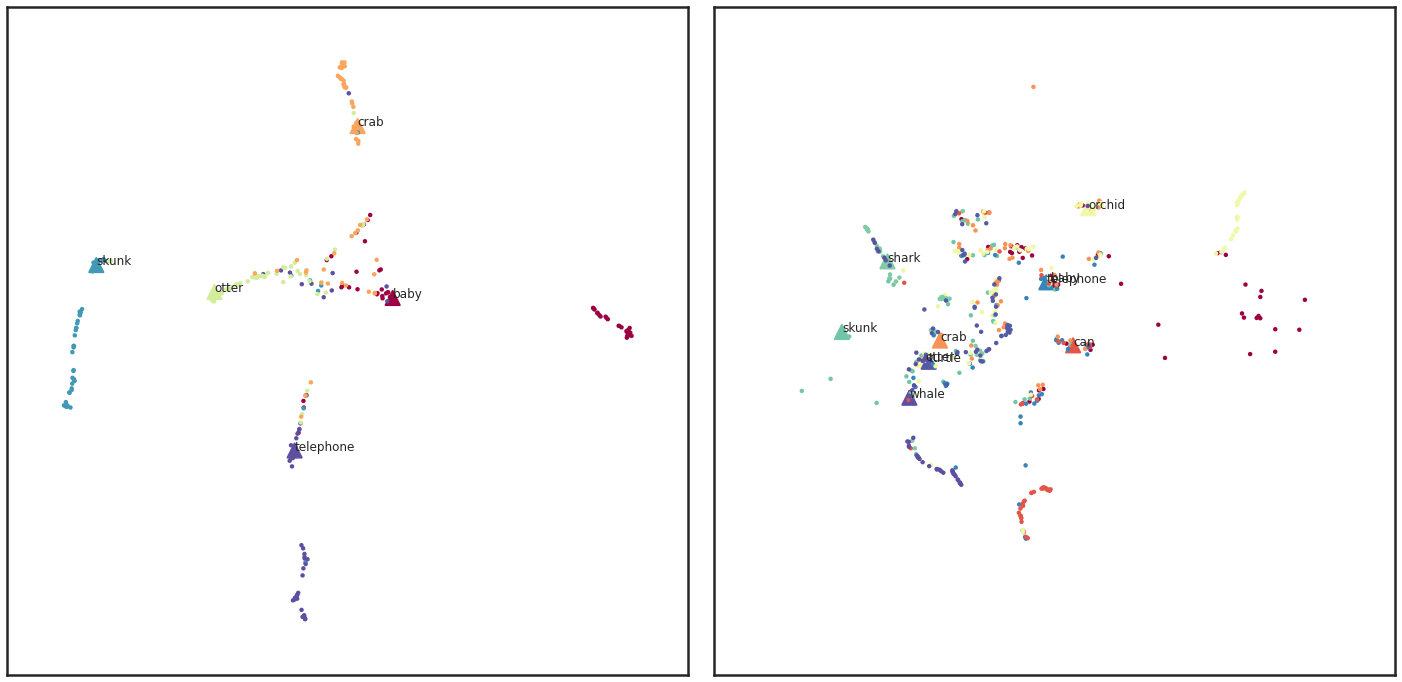

In [25]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='white', context='poster')

def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

fig, axs = plt.subplots(1,2, figsize=(20, 10))
ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    current_target = tgts[i]
    if i == 0:
        ax.scatter(*aligned_mapper.embeddings_[i][:5].T, marker='^', c=current_target[:5], s=200, cmap="Spectral")
        ax.scatter(*aligned_mapper.embeddings_[i].T, s=6, c=current_target, cmap="Spectral")
        for j, name in enumerate(class_names[:5]):
            ax.annotate(name, (aligned_mapper.embeddings_[i][:5].T[0,j] + 0.01, aligned_mapper.embeddings_[i][:5].T[1,j] + 0.01), size=12)
    else:
        ax.scatter(*aligned_mapper.embeddings_[i][0:10].T, marker='^', c=current_target[0:10], s=200, cmap="Spectral")
        ax.scatter(*aligned_mapper.embeddings_[i].T, s=6, c=current_target, cmap="Spectral")
        for j, name in enumerate(class_names):
            ax.annotate(name, (aligned_mapper.embeddings_[i][:10].T[0,j] + 0.01, aligned_mapper.embeddings_[i][:10].T[1,j] + 0.01), size=12)
    ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()

In [ ]:
from umap import AlignedUMAP as AU
slices = embs
relation_dict = {}
for i in range(255):
    relation_dict[i] = i
# for i in range(5):
#     relation_dict[i] = i
# for i in range(10,260):
#     relation_dict[i-5] = i
aligned_mapper = AU().fit(slices, relations=[relation_dict])

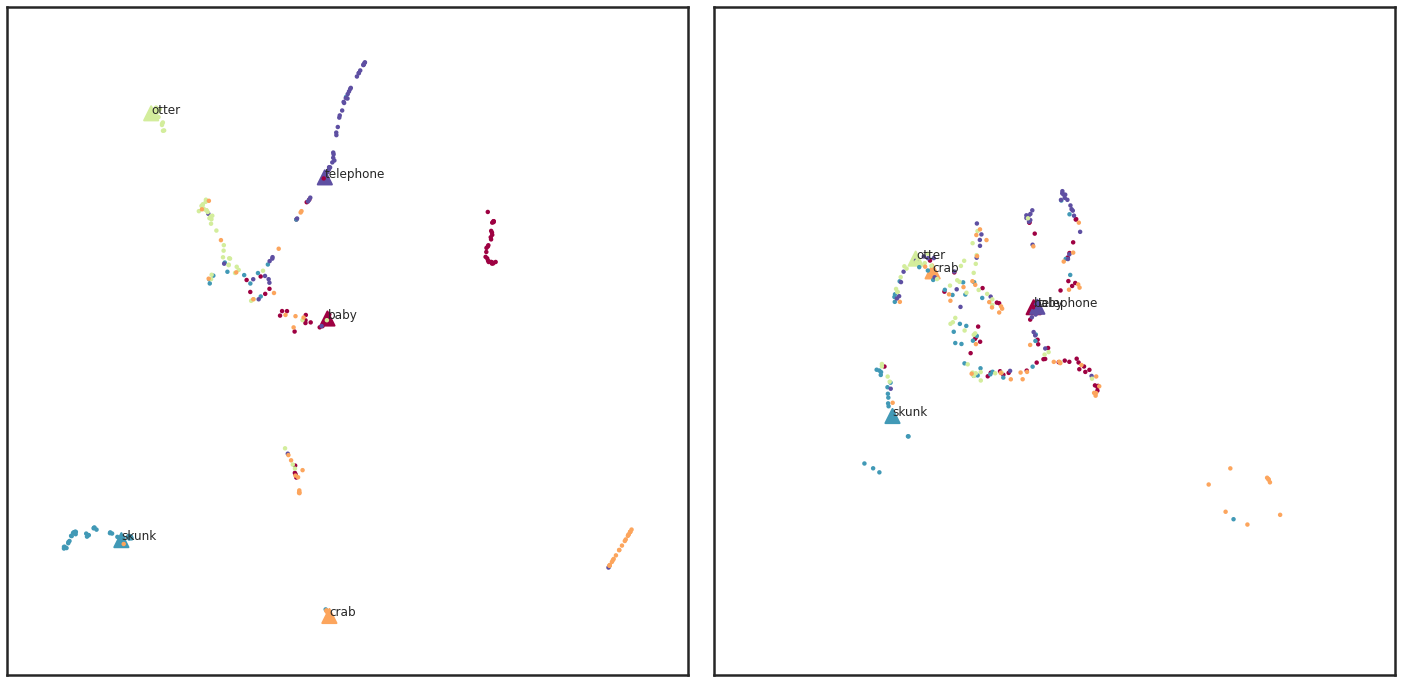

In [29]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='white', context='poster')

def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

fig, axs = plt.subplots(1,2, figsize=(20, 10))
ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    current_target = tgts[i]
    ax.scatter(*aligned_mapper.embeddings_[i][:5].T, marker='^', c=current_target[:5], s=200, cmap="Spectral")
    ax.scatter(*aligned_mapper.embeddings_[i].T, s=6, c=current_target, cmap="Spectral")
    for j, name in enumerate(class_names[:5]):
        ax.annotate(name, (aligned_mapper.embeddings_[i][:5].T[0,j] + 0.01, aligned_mapper.embeddings_[i][:5].T[1,j] + 0.01), size=12)
    ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()

In [30]:
from umap import AlignedUMAP as AU
slices = [embs[0]- 0.5, embs[0]+ 1]
relation_dict = {}
for i in range(255):
    relation_dict[i] = i
# for i in range(5):
#     relation_dict[i] = i
# for i in range(10,260):
#     relation_dict[i-5] = i
aligned_mapper = AU().fit(slices, relations=[relation_dict])

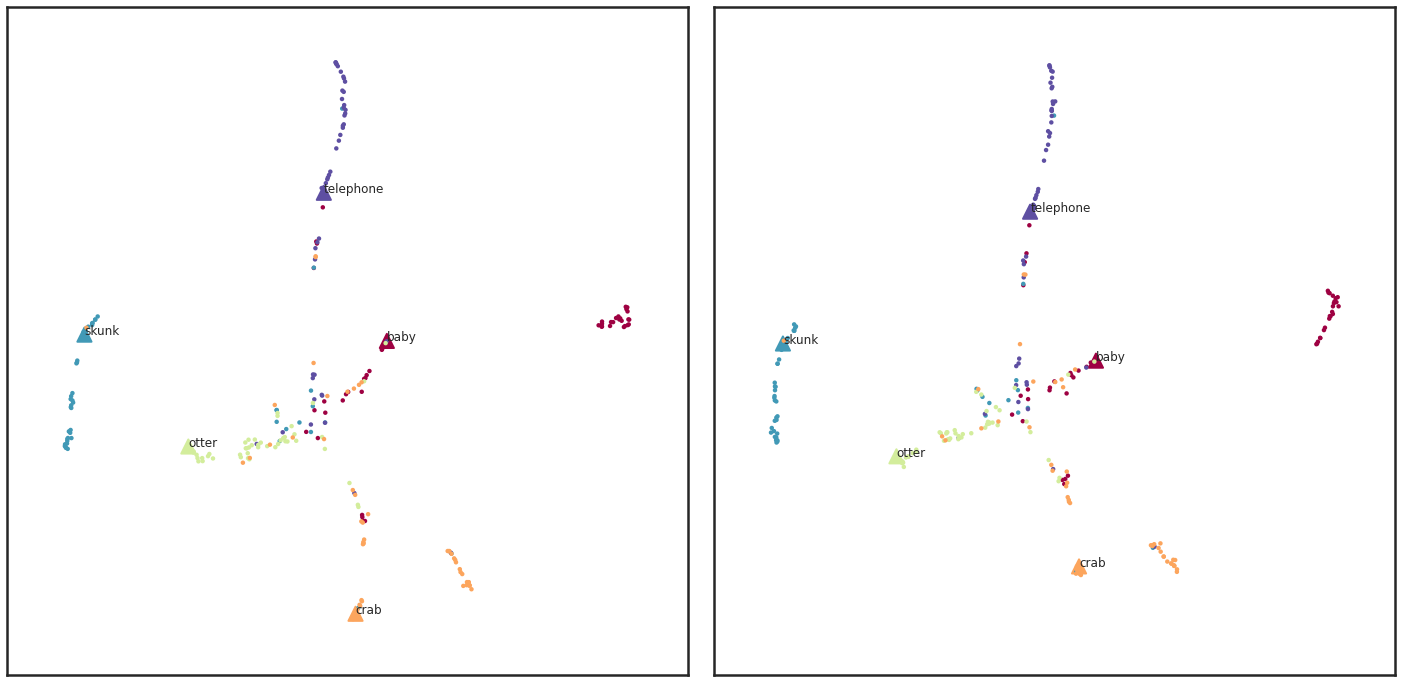

In [34]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='white', context='poster')

def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

fig, axs = plt.subplots(1,2, figsize=(20, 10))
ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    current_target = tgts[i]
    ax.scatter(*aligned_mapper.embeddings_[i][:5].T, marker='^', c=current_target[:5], s=200, cmap="Spectral")
    ax.scatter(*aligned_mapper.embeddings_[i].T, s=6, c=current_target, cmap="Spectral")
    for j, name in enumerate(class_names[:5]):
        ax.annotate(name, (aligned_mapper.embeddings_[i][:5].T[0,j] + 0.01, aligned_mapper.embeddings_[i][:5].T[1,j] + 0.01), size=12)
    ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()